# Convolutional NNs for CIFAR 10

For this project, we will use a data set of (small) natural images known as  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

**IMPORTANT NOTE:** 
In order to run this project without many issues, we ought to use a *Google Colaboratory* server equipped with a GPU, which can be achieved by:
`Edit` --> `Notebook Settings` --> Select GPU in `Hardware Accelerator`

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Download CIFAR10 with `torchvision`

The code below will download the CIFAR10 dataset, then create training and test datasets for us. 

In [ ]:
import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)
print(images.shape)

torch.Size([3, 32, 32])
torch.Size([64, 3, 32, 32])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

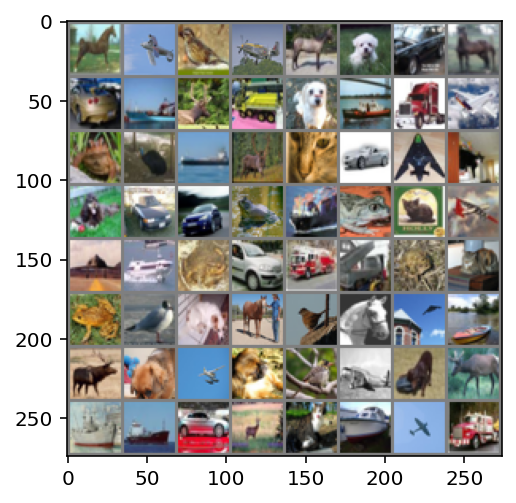

In [ ]:
imshow(utils.make_grid(images))


### Create a validation set using the 20% of train images


In [ ]:

shape_0 = trainloader.dataset.data.shape[0] 
print(shape_0)
v = int(shape_0 * 0.8)

v

50000


40000

In [ ]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:v,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:v]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[v:,:,:]
validloader.dataset.targets = validloader.dataset.targets[v:]

# now there is a validation set with 20% of the data:

validloader.dataset.data.shape

(10000, 32, 32, 3)

## Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. The original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [ ]:
Image(url= "https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg")

Image(url = 'https://www.researchgate.net/publication/341031637/figure/fig1/AS:885839181660162@1588211927876/A-classic-convolutional-neural-network-CNN-model-LeNet-5-architecture-original-image.ppm')

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

CIFAR-10 images are composed by **3 input color maps**, each of dimension $32\times32$.


In [ ]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)

        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, self.final_dim * self.final_dim * 16)
        # as we have 16 feature maps and 5*5 conv layers

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 

        return x


In [ ]:
# now the class will incorporate a training method that evaluates both validation and train losses.

class Lenet5_train(Lenet5):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []

            
    def trainloop(self, trainloader, validloader):

        for e in range(int(self.epochs)):
                        
            running_loss = 0.

            start_time = time.time()
            
            for images, labels in trainloader:  

                self.optim.zero_grad()  
                    
                out = self.forward(images)

                loss = self.criterion(out, labels)
                
                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))
            
            with torch.no_grad():

              running_loss_validation = 0.
              
              for images,labels in validloader:

                out = self.forward(images)
                  
                loss = self.criterion(out,labels)

                running_loss_validation += loss.item()
                  
              self.valid_loss_during_training.append(running_loss_validation/len(validloader))
    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
                
    def eval_performance(self, dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                probs = self.forward(images) 

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)


In [ ]:
# train the model for 5 epochs and plot the train/validation loss during training and testing.

dimx = 32
nlabels = 10

my_CNN = Lenet5_train(dimx, nlabels, epochs=5, lr=0.001)

my_CNN.trainloop(trainloader, validloader)


Epoch 1. Training loss: 1.717377, Validation loss: 1.513014, Time per epoch: 15.094128 seconds
Epoch 2. Training loss: 1.424620, Validation loss: 1.380778, Time per epoch: 15.288563 seconds
Epoch 3. Training loss: 1.301793, Validation loss: 1.269622, Time per epoch: 15.394480 seconds
Epoch 4. Training loss: 1.210003, Validation loss: 1.244992, Time per epoch: 15.070246 seconds
Epoch 5. Training loss: 1.136466, Validation loss: 1.195741, Time per epoch: 15.064943 seconds


In [ ]:
print(f'Evaluation of train: {my_CNN.eval_performance(trainloader)} \nEvaluation of test: {my_CNN.eval_performance(testloader)}')


Evaluation of train: 0.6145750284194946 
Evaluation of test: 0.5780254602432251


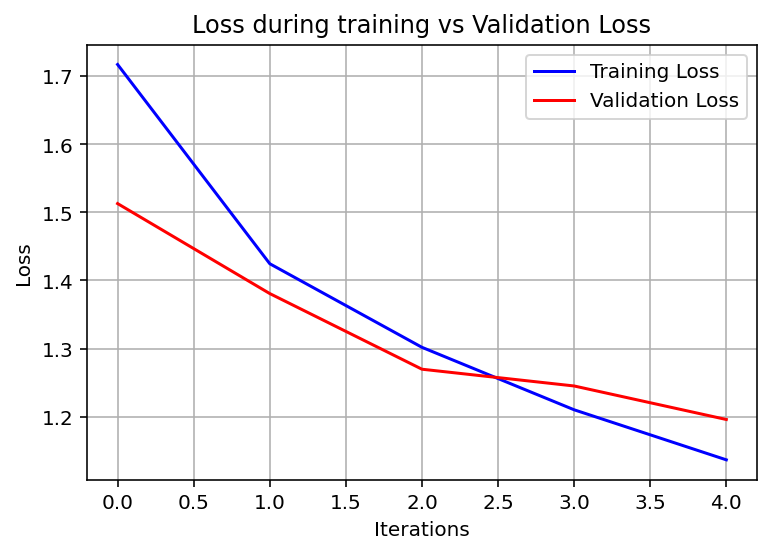

In [ ]:
plt.plot(my_CNN.loss_during_training,'-b',label='Training Loss')
plt.plot(my_CNN.valid_loss_during_training,'-r',label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during training vs Validation Loss')
plt.legend()
plt.grid()

## GPU-based training

As we noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 
From this part on, we will focus on a **gpu based** training, which will improve the results considerably.

In [ ]:
class Lenet5_extended_GPU(Lenet5):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                #Reset Gradients!
                torch.no_grad
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss_valid = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                   
                    
                    # Compute output for input minibatch
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss_valid += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss_valid/len(validloader))    
                    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
                
    def eval_performance(self, dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)                   
                probs = self.forward(images) 

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [ ]:
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=5,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,validloader)

Epoch 1. Training loss: 2.301614, Validation loss: 2.313014, Time per epoch: 9.716388 seconds
Epoch 2. Training loss: 2.314007, Validation loss: 2.312171, Time per epoch: 9.991338 seconds
Epoch 3. Training loss: 2.314342, Validation loss: 2.307323, Time per epoch: 9.821812 seconds
Epoch 4. Training loss: 2.315610, Validation loss: 2.313294, Time per epoch: 9.855463 seconds
Epoch 5. Training loss: 2.316921, Validation loss: 2.314090, Time per epoch: 9.834940 seconds


In [ ]:
print(f'Evaluation of train: {my_CNN_GPU.eval_performance(trainloader)} \nEvaluation of test: {my_CNN_GPU.eval_performance(testloader)}')

Evaluation of train: 0.10057500004768372 
Evaluation of test: 0.10041799396276474


3.067838639646244e-05 2.3124985622787473
5.7945155416004105e-06 2.311978417596999


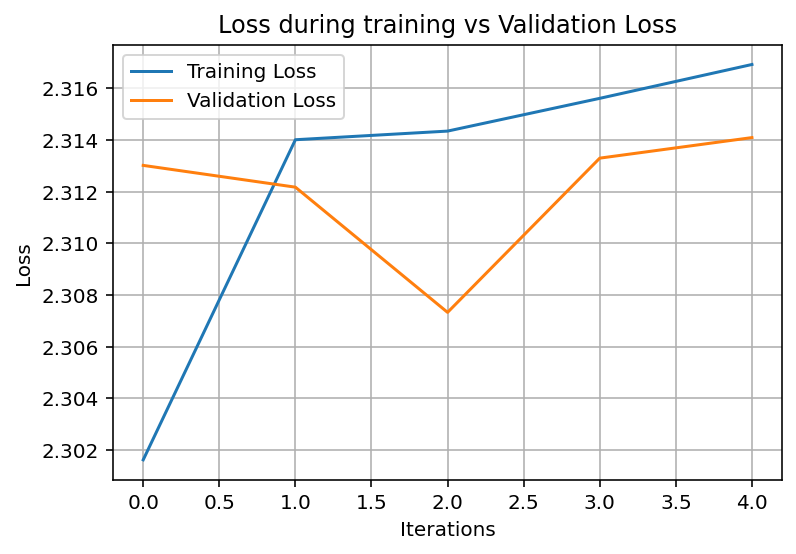

In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during training vs Validation Loss')
plt.legend()
plt.grid()


import numpy as np
print(np.var(my_CNN_GPU.loss_during_training), np.mean(my_CNN_GPU.loss_during_training))
print(np.var(my_CNN_GPU.valid_loss_during_training), np.mean(my_CNN_GPU.valid_loss_during_training))


# we can see that the values we get are almost equal, meaning there is basically no difference between training and validation! 
# (the variance is close to 0 among the elements of the list, so they are all quite similar)
# However, we see that the time to train has decreased significantly.
# Also, the evaluation works far better when we are not considering GPU.

With a GPU, it can be seen that the time per epoch roughly decreases significantly. As we train deeper and much more complex networks, **this difference grows exponentially fast**. 

## Regularize the network and compare with a MLP

We will now do the following:

> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. In my experience.
> - Check the train/validation/test performance, plot the train and validation losses

In [ ]:
# Check overfitting: We will train for a longer time to see the results. Firstly, Dropout will not be considered.

my_CNN = Lenet5_train(dimx=32,nlabels=10,epochs=60,lr=1e-3)

my_CNN.trainloop(trainloader, validloader)


Epoch 1. Training loss: 1.694997, Validation loss: 1.466052, Time per epoch: 15.305262 seconds
Epoch 2. Training loss: 1.387801, Validation loss: 1.386485, Time per epoch: 15.631254 seconds
Epoch 3. Training loss: 1.271811, Validation loss: 1.270810, Time per epoch: 15.617932 seconds
Epoch 4. Training loss: 1.195668, Validation loss: 1.213732, Time per epoch: 15.462864 seconds
Epoch 5. Training loss: 1.130633, Validation loss: 1.163836, Time per epoch: 15.254117 seconds
Epoch 6. Training loss: 1.077061, Validation loss: 1.132455, Time per epoch: 15.358897 seconds
Epoch 7. Training loss: 1.029539, Validation loss: 1.125167, Time per epoch: 15.461464 seconds
Epoch 8. Training loss: 0.997168, Validation loss: 1.105898, Time per epoch: 15.582144 seconds
Epoch 9. Training loss: 0.953898, Validation loss: 1.083050, Time per epoch: 15.362323 seconds
Epoch 10. Training loss: 0.918362, Validation loss: 1.105036, Time per epoch: 15.286462 seconds
Epoch 11. Training loss: 0.883117, Validation los

In [ ]:
print(f'Mean of train: {np.mean(my_CNN.loss_during_training)} VS Mean of validation: {np.mean(my_CNN.valid_loss_during_training)}')
print(f'Evaluation of train: {my_CNN.eval_performance(trainloader)} \nEvaluation of test: {my_CNN.eval_performance(testloader)}')

# We can see that the validation loss is much higher, and the train loss is much lower
# Also, the train and test results are indicating of a clear overfitting!

Mean of train: 0.5682054262691735 VS Mean of validation: 1.7219153433563605
Evaluation of train: 0.9333750009536743 
Evaluation of test: 0.587579607963562


In [ ]:
# Regularize with Early Stopping and Dropout

class Lenet5_dropout(nn.Module):
    def __init__(self,dimx,nlabels,p): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        # 16*5*5, 32 * 32 * 5
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)

        self.dropout = nn.Dropout(p=p)

        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)

        x = self.dropout(x)

        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, self.final_dim * self.final_dim * 16)
        # as we have 16 feature maps and 5*5 conv layers

        x = self.dropout(x)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 

        return x



In [ ]:

class Lenet5_train_Dropout(Lenet5_dropout):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001,p=0.2):
        
        super().__init__(dimx,nlabels,p)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []

            
    def trainloop(self, trainloader, validloader):

        for e in range(int(self.epochs)):
                        
            running_loss = 0.

            start_time = time.time()
            
            for images, labels in trainloader:  

                self.optim.zero_grad()  
                    
                out = self.forward(images)

                loss = self.criterion(out, labels)
                
                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))
            
            with torch.no_grad():

              running_loss_validation = 0.
              
              for images,labels in validloader:

                out = self.forward(images)
                  
                loss = self.criterion(out,labels)

                running_loss_validation += loss.item()
                  
              self.valid_loss_during_training.append(running_loss_validation/len(validloader))
    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
                
    def eval_performance(self, dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                probs = self.forward(images) 

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [ ]:

my_CNN_dropout = Lenet5_train_Dropout(dimx=32,nlabels=10,epochs=60,lr=1e-3,p=0.2)

my_CNN_dropout.trainloop(trainloader, validloader)

Epoch 1. Training loss: 1.750080, Validation loss: 1.528764, Time per epoch: 15.145326 seconds
Epoch 2. Training loss: 1.454061, Validation loss: 1.415298, Time per epoch: 15.348904 seconds
Epoch 3. Training loss: 1.349986, Validation loss: 1.354915, Time per epoch: 15.639485 seconds
Epoch 4. Training loss: 1.279470, Validation loss: 1.327049, Time per epoch: 15.582322 seconds
Epoch 5. Training loss: 1.217530, Validation loss: 1.252056, Time per epoch: 15.540553 seconds
Epoch 6. Training loss: 1.177157, Validation loss: 1.226076, Time per epoch: 15.584591 seconds
Epoch 7. Training loss: 1.139478, Validation loss: 1.211086, Time per epoch: 15.531358 seconds
Epoch 8. Training loss: 1.098631, Validation loss: 1.180867, Time per epoch: 15.508092 seconds
Epoch 9. Training loss: 1.073206, Validation loss: 1.177343, Time per epoch: 15.713218 seconds
Epoch 10. Training loss: 1.049071, Validation loss: 1.163663, Time per epoch: 15.389325 seconds
Epoch 11. Training loss: 1.022378, Validation los

In [ ]:
print(f'Evaluation of train: {my_CNN_dropout.eval_performance(trainloader)} \nEvaluation of test: {my_CNN_dropout.eval_performance(testloader)}')

Evaluation of train: 0.7612000107765198 
Evaluation of test: 0.6106687784194946


Mean of train: 0.8643263248697917 VS Mean of validation: 1.184248449034878


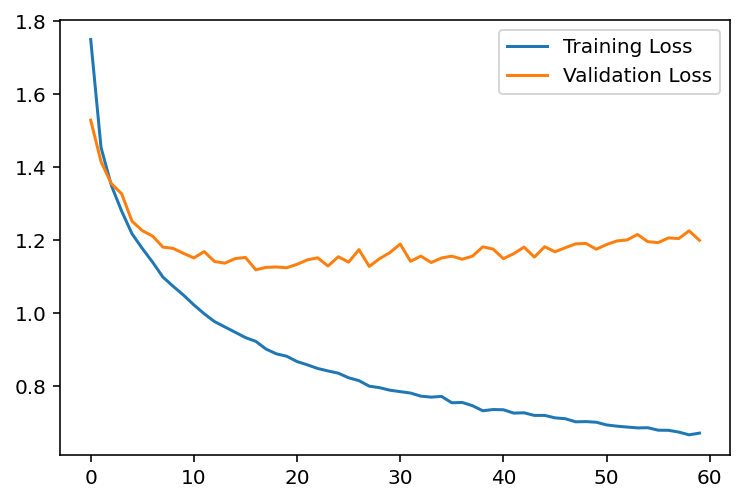

In [ ]:
# check train/validation/test and Plot of the results:

print(f'Mean of train: {np.mean(my_CNN_dropout.loss_during_training)} VS Mean of validation: {np.mean(my_CNN_dropout.valid_loss_during_training)}')

plt.plot(my_CNN_dropout.loss_during_training,label='Training Loss')
plt.plot(my_CNN_dropout.valid_loss_during_training,label='Validation Loss')
plt.legend()


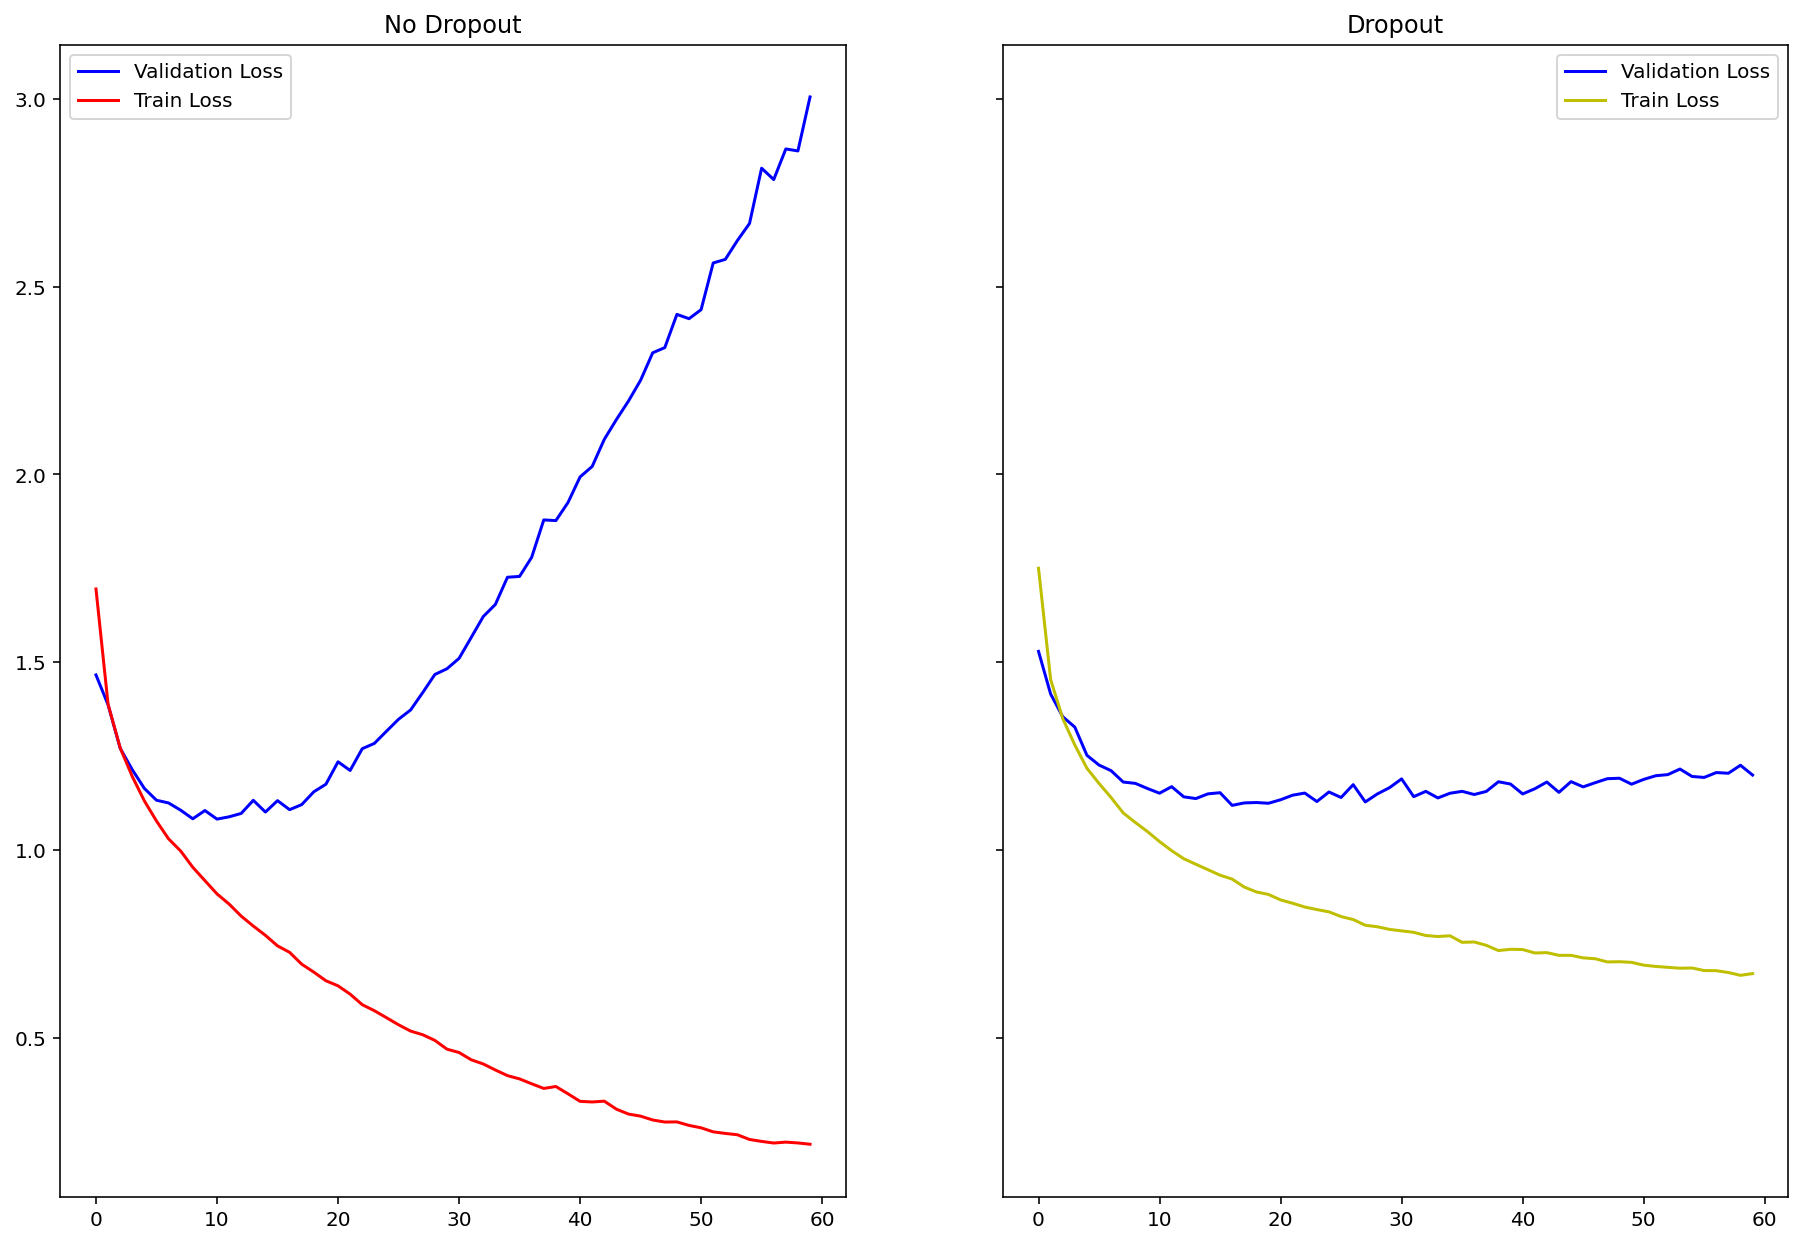

In [ ]:
# Comparison between Dropout vs No Dropout:

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(my_CNN.valid_loss_during_training,'-b',label='Validation Loss')
axs[0].plot(my_CNN.loss_during_training,'-r',label='Train Loss')
axs[0].set_title('No Dropout')
axs[0].legend()

axs[1].plot(my_CNN_dropout.valid_loss_during_training,'-b',label='Validation Loss')
axs[1].plot(my_CNN_dropout.loss_during_training,'-y',label='Train Loss')
axs[1].set_title('Dropout')
axs[1].legend()

plt.subplots_adjust(left=1, bottom=1, right=3, top=3, wspace=0.2, hspace=0.2)
plt.show()

Taking a look at these plots, we find that each model has its advantages and disadvantages:

Regarding the model without Dropout, its training loss is lower, but the validation loss does not perform well, and increases as the model iterations increase: A clear sign of $overfitting$. 

On the other hand, when we consider Dropout, the validation loss stabilized along a certain value, but the training losses are higher than without Dropout. 

## In conclusion:

In this lab we have seen that an MLP is able to overfit and obtain good training and testing results. A CNN is able to obtain similar results as well. 